#### Defining imports

In [1]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets # Has standard datasets we can import in a nice and easy way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
from torch.utils.data import TensorDataset
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split

#### Preparing training and testing dataset

In [2]:
dataframe_final = pd.read_csv("../fingerPrintDataAllChem2048", index_col=False).drop(["Unnamed: 0"], axis =1)
print(f'All data \n{dataframe_final}')

X_dataframe = dataframe_final.iloc[:,:dataframe_final.shape[1]-1]
print(f'\nTrain data \n{X_dataframe}')

y_dataframe = dataframe_final.iloc[:,-1]
print(f'\nLabels \n{y_dataframe}')

X_train, X_test, y_train, y_test = train_test_split(X_dataframe, y_dataframe, stratify=y_dataframe, test_size = 0.2, random_state=42)


batch_size = 256
X_train_torch = torch.from_numpy(X_train.values.astype(np.float32))
y_train_torch = torch.from_numpy(y_train.values.astype(np.float32))
X_test_torch = torch.from_numpy(X_test.values.astype(np.float32))
y_test_torch = torch.from_numpy(y_test.values.astype(np.float32))

train_ds = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_ds, batch_size, shuffle=True)

test_ds = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_ds, batch_size, shuffle=True)

All data 
        0  1  2  3  4  5  6  7  8  9  ...  2039  2040  2041  2042  2043  2044  \
0       1  1  1  1  1  0  0  0  1  0  ...     0     1     1     0     0     0   
1       0  0  0  0  1  0  1  0  0  0  ...     1     0     0     0     0     0   
2       1  0  0  0  1  0  1  0  0  0  ...     0     0     0     0     0     1   
3       0  0  1  0  1  1  1  0  0  0  ...     1     0     0     0     0     0   
4       1  1  1  0  1  1  1  0  0  0  ...     0     1     0     0     0     0   
...    .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
193709  1  0  1  1  1  0  1  0  0  0  ...     0     0     0     0     0     0   
193710  1  1  1  0  1  0  1  0  1  0  ...     1     1     0     0     0     0   
193711  1  1  1  0  1  0  0  0  1  0  ...     0     1     0     0     0     0   
193712  1  1  1  1  1  0  0  0  0  0  ...     0     1     0     0     0     0   
193713  1  0  1  1  1  1  1  0  0  0  ...     0     1     0     0     0     0   

        2045  204

#### Build Model

In [3]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 250)
        self.fc3 = nn.Linear(250, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

#### Defining hyperparameters

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 2048
num_classes = 2
learning_rate = 0.0001
#num_epochs = 10

batch_size = 256
n_iters = 70000
num_epochs = n_iters / (len(train_ds) / batch_size)
num_epochs = int(num_epochs)

model = NN(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### Model training

In [5]:
for batch_idx, (data, targets) in enumerate(train_loader):
    print(data.shape)
    print(targets.shape)
    
    break

torch.Size([256, 2048])
torch.Size([256])


In [6]:
for epoch in range(num_epochs):
    #print(f"Epoch: {epoch}")
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        targets=targets.to(torch.int64)

        # forward propagation
        scores = model(data)
        #print(scores)
        loss = criterion(scores, targets)
        
        # zero previous gradients
        optimizer.zero_grad()
        
        # back-propagation
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 0.1033
Epoch 10  Loss 0.0002
Epoch 20  Loss 0.0000
Epoch 30  Loss 0.0000
Epoch 40  Loss 0.0079
Epoch 50  Loss 0.0000
Epoch 60  Loss 0.0000
Epoch 70  Loss 0.0000
Epoch 80  Loss 0.0000
Epoch 90  Loss 0.0000
Epoch 100  Loss 0.0000
Epoch 110  Loss 0.0000


#### Model Testing

In [7]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    predictionArr = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            predictionArr.append(predictions)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy"
            f" {float(num_correct) / float(num_samples) * 100:.2f}"
        )

    model.train()
    return predictionArr

#### Evaluation

In [8]:
predictions_train = check_accuracy(train_loader, model)
predictions_test = check_accuracy(test_loader, model)

Got 154954 / 154971 with accuracy 99.99
Got 38433 / 38743 with accuracy 99.20


In [9]:
finalTrainPredictions = []
for t,l in enumerate(predictions_train):
    for p in l:
        finalTrainPredictions.append(p.cpu().detach().numpy())
        
finalTestPredictions = []
for t,l in enumerate(predictions_test):
    for p in l:
        finalTestPredictions.append(p.cpu().detach().numpy())

finalTrainPredictions = np.array(finalTrainPredictions)
finalTestPredictions = np.array(finalTestPredictions)

In [10]:
#m = np.array(y_test)
#finalTestPredictions

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
unique, counts = np.unique(m, return_counts=True)
print(f'Actual Unique values for testing data: {unique}')
print(f'Actual Count of zeros and ones for testing data: {counts}')
unique, counts = np.unique(finalTestPredictions, return_counts=True)
print(f'Predicted Unique values for testing data: {unique}')
print(f'Predicted Count of zeros and ones for testing data: {counts}')

Actual Unique values for testing data: [0 1]
Actual Count of zeros and ones for testing data: [38425   318]
Predicted Unique values for testing data: [0 1]
Predicted Count of zeros and ones for testing data: [38637   106]


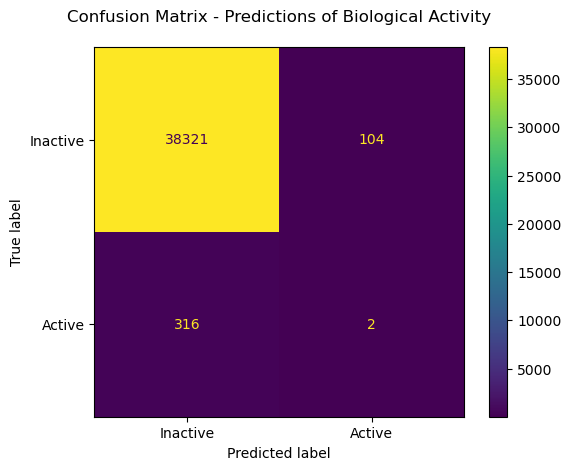

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

import matplotlib.pyplot as plt
plt.style.use('default')

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(m, finalTestPredictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.yticks(ticks = [0,1], labels=['Inactive', 'Active'])
plt.xticks(ticks = [0,1], labels=['Inactive', 'Active'])
plt.title("Confusion Matrix - Predictions of Biological Activity\n")
plt.show()